In [1]:
import os
import re
import math

import numpy as np
import pandas as pd
from scipy import stats
from scipy import spatial
from typing import Union, List
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import matplotlib.patches as patches

import MSDiversity as msd
# from voronoi import draw_voronoi_scatter
from tqdm import tqdm 

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

# Helper Functions

In [3]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [4]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [5]:
def calculate_interactions(dataframe):
    interactions = {}
    all_cell_types = set(dataframe.columns.get_level_values(0).unique().tolist() + dataframe.columns.get_level_values(1).unique().tolist())
    
    for cell_type in all_cell_types:
        # Find all columns where the cell type is present
        related_columns = (dataframe.columns.get_level_values(0) == cell_type) | (dataframe.columns.get_level_values(1) == cell_type)
        
        # Get the unique cell types interacting with the given cell type
        interacting_cell_types = set(dataframe.columns[related_columns].get_level_values(0).unique().tolist() + dataframe.columns[related_columns].get_level_values(1).unique().tolist())
        
        # Remove the cell type itself from the set of interacting cell types
        interacting_cell_types.discard(cell_type)
        
        # Store the number of unique interacting cell types
        interactions[cell_type] = len(interacting_cell_types)
    
    return interactions

# Simulation Functions

In [6]:
def simulate_spatial_distribution(num_samples: int, 
                                  num_celltypes: int, 
                                  cells_per_type: Union[int, List[int]], 
                                  distribution_range: List[int], 
                                  clumped_cell_types=[0],
                                  num_clusters=10, 
                                  radius=150,
                                  seed=42): 
    np.random.seed(seed)  # Setting the seed
    dfs = []
    if clumped_cell_types is None:
        clumped_cell_types = []
        
    for sample_id in range(1, num_samples + 1):
        X, Y, cell_types = [], [], []
        cluster_centers = []

        for cell_type in range(num_celltypes):
            if cell_type in clumped_cell_types:
                # Clumped distribution for cell types in clumped_cell_types
                cells_per_cluster = cells_per_type[cell_type]//num_clusters
                for _ in range(num_clusters):
                    # Generate a random radius variation ±10%
                    random_radius = radius * np.random.uniform(0.8, 1.2)
                    center_sd = 0
                    if random_radius > (distribution_range[cell_type][0] - distribution_range[cell_type][1])/2:
                        center_sd = 0.6*random_radius
                    x_center = np.random.uniform(distribution_range[cell_type][0]+center_sd, distribution_range[cell_type][1]-center_sd)
                    y_center = np.random.uniform(distribution_range[cell_type][0]+center_sd, distribution_range[cell_type][1]-center_sd)
                    for _ in range(cells_per_cluster):
                        if np.random.rand() > 0.2:  # 20% chance not to clump
                            valid = False
                            while not valid:
                                angle = 2 * np.pi * np.random.uniform(0, 1)  # Randomly choose an angle
                                distance = np.sqrt(np.random.uniform(0, 1)) * random_radius
                                x = x_center + distance * np.cos(angle)
                                y = y_center + distance * np.sin(angle)
                                if distribution_range[cell_type][0] <= x <= distribution_range[cell_type][1] and distribution_range[cell_type][0] <= y <= distribution_range[cell_type][1]:
                                    valid = True
                            X.append(x)
                            Y.append(y)
                        else:
                            # Place some cells outside the cluster
                            x = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                            y = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                            X.append(x)
                            Y.append(y)
                    cluster_centers.append([x_center, y_center])
            else:
                # Uniform random distribution for other cell types
                for _ in range(cells_per_type[cell_type]):
                    too_close = True
                    while too_close:
                        X_temp = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                        Y_temp = np.random.uniform(distribution_range[cell_type][0], distribution_range[cell_type][1])
                        if cluster_centers:  # if there are points in cluster_centers
                            distances = spatial.distance.cdist([[X_temp, Y_temp]], cluster_centers, 'euclidean')
                            too_close = np.any(distances < radius)
                        else:  # if there are no points in cluster_centers
                            too_close = False
                    X.append(X_temp)
                    Y.append(Y_temp)
            cell_types.extend([cell_type] * cells_per_type[cell_type])

        # Creating a DataFrame to hold this sample's data
        sample_df = pd.DataFrame({
            'X': X,
            'Y': Y,
            'cell_type': cell_types,
            'sample': sample_id
        })

        # Appending the data to the list of dataframes
        dfs.append(sample_df)

    # Concatenating all dataframes
    protein = pd.concat(dfs)
    # Resetting the index
    protein.reset_index(drop=True, inplace=True)

    return protein


# Non-Self-Similar simulation

In [94]:
total_cells_per_sample = 10000
cell_types_proportions = [0.4,0.3,0.15,0.1,0.05]
num_celltypes = len(cell_types_proportions)
protein_cond1 = simulate_spatial_distribution(num_samples=10, 
                                              num_celltypes=num_celltypes, 
                                              cells_per_type= [int(cp*total_cells_per_sample) for cp in cell_types_proportions], 
                                              distribution_range=[(0,1600)]*num_celltypes, 
                                              clumped_cell_types=None,
                                              num_clusters=None, 
                                              radius=None)
protein_cond1['Condition'] = 'Cond1'
protein_cond1['sample'] = protein_cond1['sample'].apply(lambda x: 'Cond1_' + str(x))

# protein_cond2 = simulate_spatial_distribution(num_samples=10, 
#                                               num_celltypes=num_celltypes, 
#                                               cells_per_type= [int(cp*total_cells_per_sample) for cp in cell_types_proportions], 
#                                               distribution_range=[(0,1600)]*num_celltypes, 
#                                               clumped_cell_types=[3],
#                                               num_clusters=2, 
#                                               radius=250)

protein_cond2 = simulate_spatial_distribution(num_samples=10, 
                                              num_celltypes=num_celltypes, 
                                              cells_per_type= [int(cp*total_cells_per_sample) for cp in cell_types_proportions], 
                                              distribution_range=[(0,1600)]*num_celltypes, 
                                              clumped_cell_types=None,
                                              num_clusters=None, 
                                              radius=None,
                                              seed=41)

protein_cond2['Condition'] = 'Cond2'
protein_cond2['sample'] = protein_cond2['sample'].apply(lambda x: 'Cond2_' + str(x))

In [95]:
protein = pd.concat([protein_cond1, protein_cond2], ignore_index=True)
protein

,X,Y,cell_type,sample,Condition
0,599.264190,1521.142890,0,Cond1_1,Cond1
1,1171.190307,957.853575,0,Cond1_1,Cond1
2,249.629825,249.591233,0,Cond1_1,Cond1
3,92.933779,1385.881833,0,Cond1_1,Cond1
4,961.784019,1132.916124,0,Cond1_1,Cond1
...,...,...,...,...,...
199995,1368.594010,1064.064839,4,Cond2_10,Cond2
199996,335.655315,423.597725,4,Cond2_10,Cond2
199997,927.949594,634.028997,4,Cond2_10,Cond2
199998,322.854579,788.243936,4,Cond2_10,Cond2


In [64]:
pwd

'/Users/Emrys/Downloads/MESA/ecological_spatial'

In [105]:
protein.to_csv('../../simulated_spatial_data_nodiff.csv', index=False) 

In [6]:
file_name = 'simulated_spatial_data_nodiff.csv'
protein = pd.read_csv('../../'+file_name)

# Plot Simulated Data

In [15]:
tulip = ['#F21D44','#F288AF','#72A603','#F2C48D','#FF9F18']
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#000075','#46f0f0', 
                 '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#f032e6','#bcf60c',
                 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#911eb4', '#808080', '#000000']

In [16]:
bokai_palette1 = dict(zip(pd.unique(protein['cell_type']), bokai_palette))

In [22]:
library_id = 'Cond2_1'
protein_region = protein.loc[protein['sample'] == library_id,:]
patches_coordinates = msd.generate_patches(protein, 'sample', library_id, scaling_factor= 8., spatial_key=['X','Y'])

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20625/1508599321.py:3: UserWarning: The palette list has more values (21) than needed (5), which may not be intended.
  sns.scatterplot(data=protein_region, x="X", y="Y", hue="cell_type", palette=bokai_palette, s=9, legend='full', rasterized=True,ax=axes)


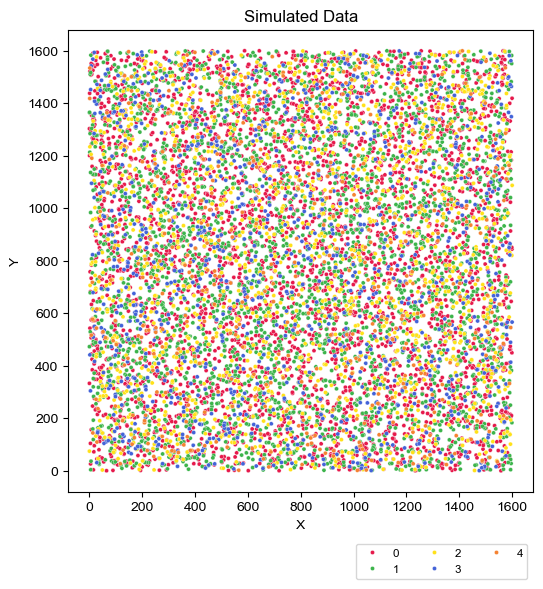

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

sns.scatterplot(data=protein_region, x="X", y="Y", hue="cell_type", palette=bokai_palette, s=9, legend='full', rasterized=True,ax=axes)
axes.set_title('Simulated Data')
axes.legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')

plt.savefig("../figures/simulation/"+library_id+file_name.split('.')[0].split('_')[-1]+".svg", dpi=300)
plt.show()

In [ ]:
_, fig = draw_voronoi_scatter(protein_region,
                         [],
                         voronoi_palette = sns.color_palette(tulip), 
                         X = 'X', 
                         Y = 'Y', 
                         voronoi_hue = 'cell_type',
                         voronoi_kwargs = {'edge_color':'white','line_width' : 0.31})
fig.savefig("./fig1.svg")

# Apply MESA on Simulated Data

In [7]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32.]

In [8]:
# Define the library_ids
library_ids = protein['sample'].unique()

In [9]:
df_entropy, df_slopes = msd.multiscale_diversity(spatial_data=protein,
                                                 scales=scales,
                                                 library_key='sample',
                                                 library_ids=library_ids,
                                                 spatial_key=['X','Y'],
                                                 cluster_key='cell_type',
                                                 random_patch=False,
                                                 plotfigs=False,
                                                 savefigs=False,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

Processing region: Cond1_1 at scale 1.0
0.000 per cent patches are empty
Cond1_1 at scale 1.0 has 0 patches with zero diveristy
Cond1_1 at scale 1.0 diversity is 2.008694969562842
Processing region: Cond1_2 at scale 1.0
0.000 per cent patches are empty
Cond1_2 at scale 1.0 has 0 patches with zero diveristy
Cond1_2 at scale 1.0 diversity is 2.008694969562842
Processing region: Cond1_3 at scale 1.0
0.000 per cent patches are empty
Cond1_3 at scale 1.0 has 0 patches with zero diveristy
Cond1_3 at scale 1.0 diversity is 2.008694969562842
Processing region: Cond1_4 at scale 1.0
0.000 per cent patches are empty
Cond1_4 at scale 1.0 has 0 patches with zero diveristy
Cond1_4 at scale 1.0 diversity is 2.008694969562842
Processing region: Cond1_5 at scale 1.0
0.000 per cent patches are empty
Cond1_5 at scale 1.0 has 0 patches with zero diveristy
Cond1_5 at scale 1.0 diversity is 2.008694969562842
Processing region: Cond1_6 at scale 1.0
0.000 per cent patches are empty
Cond1_6 at scale 1.0 has 0 

In [10]:
df_results = pd.concat([df_entropy.transpose(), df_slopes.transpose()], axis=1)
df_results=df_results.rename(columns={0.0: 'Slope'})
df_results['Condition'] = ' '
df_results['Sample_id'] = df_results.index
df_results.loc[df_results.index.str.contains('Cond1'), 'Condition'] = 'Cond1'
df_results.loc[df_results.index.str.contains('Cond2'), 'Condition'] = 'Cond2'
# for col in df_results.columns[:-2]:  # Exclude 'Slope' and 'Condition'
#     df_results[f'Avg_{col}'] = df_results.groupby('Condition')[col].transform('mean')
df_results

,1.0,2.0,4.0,8.0,16.0,32.0,Slope,Condition,Sample_id
Cond1_1,2.008695,2.007342,2.004265,1.988279,1.928136,1.630856,0.061223,Cond1,Cond1_1
Cond1_2,2.008695,2.007893,2.003837,1.992717,1.930354,1.647605,0.058548,Cond1,Cond1_2
Cond1_3,2.008695,2.008076,2.002989,1.989973,1.918955,1.633894,0.061554,Cond1,Cond1_3
Cond1_4,2.008695,2.008015,2.003832,1.990268,1.928518,1.637479,0.060232,Cond1,Cond1_4
Cond1_5,2.008695,2.008119,2.004525,1.99078,1.931089,1.645335,0.058904,Cond1,Cond1_5
Cond1_6,2.008695,2.008166,2.005066,1.989137,1.926461,1.630211,0.061528,Cond1,Cond1_6
Cond1_7,2.008695,2.008092,2.003292,1.987904,1.924618,1.630539,0.061617,Cond1,Cond1_7
Cond1_8,2.008695,2.007689,2.002196,1.987975,1.925785,1.633266,0.061059,Cond1,Cond1_8
Cond1_9,2.008695,2.007765,2.0036,1.988526,1.924773,1.637919,0.060512,Cond1,Cond1_9
Cond1_10,2.008564,2.007847,2.004248,1.98927,1.914862,1.633342,0.062001,Cond1,Cond1_10


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20625/1634691501.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='Condition', y='Slope', ax=ax, palette="muted", width=0.5, boxprops=dict(alpha=.3))
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20625/1634691501.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20625/1634691501.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(dat

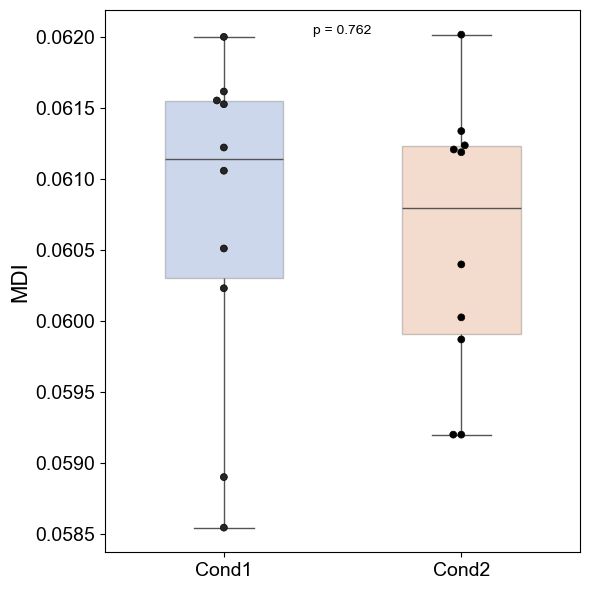

In [12]:
# Set a style that's commonly used for publications
fig, ax = plt.subplots(figsize=(6, 6))

# Boxplot
sns.boxplot(data=df_results, x='Condition', y='Slope', ax=ax, palette="muted", width=0.5, boxprops=dict(alpha=.3))
sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)

# Labeling and titling
ax.set_ylabel('MDI', fontsize=16) 
ax.set_xlabel('') 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Separate data into two conditions
data_condition_1 = df_results[df_results['Condition'] == 'Cond1']['Slope']
data_condition_2 = df_results[df_results['Condition'] == 'Cond2']['Slope']

# Perform Mann-Whitney U test
#U_stat, p_val = stats.mannwhitneyu(data_condition_1, data_condition_2, alternative='two-sided')
stat, p_val = stats.ttest_ind(data_condition_1, data_condition_2 ,equal_var=False)

ax.text(0.5, 0.95, f'p = {p_val:.3f}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)

plt.tight_layout()

save_path = 'MDI_simulated'+ file_name.split('.')[0].split('_')[-1] +'.svg'
fig = plt.gcf()
fig.savefig('../figures/simulation/'+save_path)

plt.show()
plt.close(fig)

In [13]:
Hot = True
library_names = ['Cond1', 'Cond2'] 
library_ids = [protein['sample'].unique().tolist()[:10], 
               protein['sample'].unique().tolist()[10:]]

total_merged_series = []

comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=protein, 
                                                                              scale=32.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key=['X','Y'],
                                                                              cluster_key='cell_type',
                                                                              hotspot=Hot,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=False,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

Processing region: Cond1_1 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_1 contains 9 diversity hotspots
Considering only hotspots
Processing region: Cond1_2 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_2 contains 6 diversity hotspots
Considering only hotspots
Processing region: Cond1_3 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_3 contains 6 diversity hotspots
Considering only hotspots
Processing region: Cond1_4 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_4 contains 7 diversity hotspots
Considering only hotspots
Processing region: Cond1_5 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_5 contains 3 diversity hotspots
Considering only hotspots
Processing region: Cond1_6 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_6 contains 3 diversity hotspots
Considering only hotspots
Processing region: Cond1_7 at scale 32.0
0.000 per c

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20625/1965373599.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black',


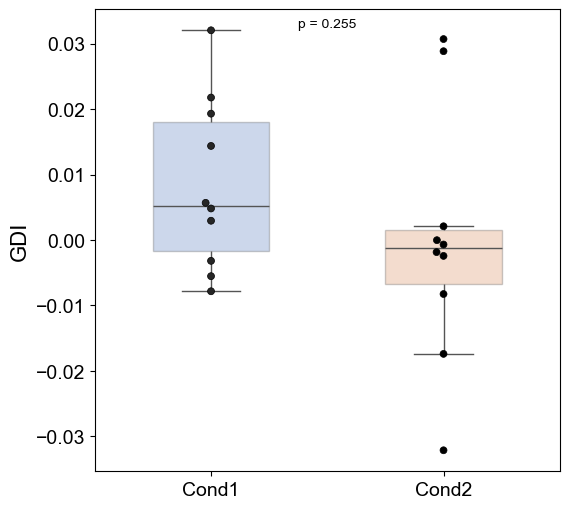

In [14]:
# Extract data for boxplot
balbc_data = [v[0] for k, v in moran_results[0].items()]
mrl_data = [v[0] for k, v in moran_results[1].items()]

# Mann-Whitney U test
# stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data)
stat, p_value = stats.ttest_ind(balbc_data, mrl_data, equal_var=False)

# Combining data
data = [balbc_data, mrl_data]
labels = ['Cond1', 'Cond2']

# Plotting
plt.figure(figsize=(6, 6)) 
sns.boxplot(data=data, palette="muted", 
            boxprops=dict(alpha=.3), width=0.5, fliersize=0)  # Adjusted width here

sns.swarmplot(data=data, palette='dark:black', 
              edgecolor='gray', linewidth=0.5, size=5)

plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("GDI", fontsize=16)
# plt.title(f'{mode}', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')
save_path = 'GDCI_simulated'+ file_name.split('.')[0].split('_')[-1] +'.svg'
fig = plt.gcf()
fig.savefig('../figures/simulation/'+save_path)

plt.show()
plt.close(fig)

In [23]:
Hot = False
library_names = ['Cond1', 'Cond2'] 
library_ids = [protein['sample'].unique().tolist()[:10], 
               protein['sample'].unique().tolist()[10:]]
PX_results = []


for library, library_name in zip(library_ids, library_names):
    proximity_I = msd.sample_proximity(spatial_data=protein, 
                                       scale=32.0, 
                                       library_key='sample',
                                       library_ids=library, 
                                       spatial_key=['X', 'Y'],
                                       cluster_key='cell_type',
                                       hotspot=Hot,
                                       metric='Shannon Diversity')
    # Store PX 
    PX_results.append(proximity_I)


Processing region: Cond1_1 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_1 contains 5 diversity coldspots
4 islands identified
Processing region: Cond1_2 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_2 contains 4 diversity coldspots
2 islands identified
Processing region: Cond1_3 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_3 contains 7 diversity coldspots
6 islands identified
Processing region: Cond1_4 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_4 contains 1 diversity coldspots
1 islands identified
Processing region: Cond1_5 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_5 contains 1 diversity coldspots
1 islands identified
Processing region: Cond1_6 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Region Cond1_6 contains 6 diversity coldspots
4 islands identified
Processing region: Cond1_7 at scale 32.0
0.000 per cent patches are empty
Us

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20378/1468697670.py:21: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


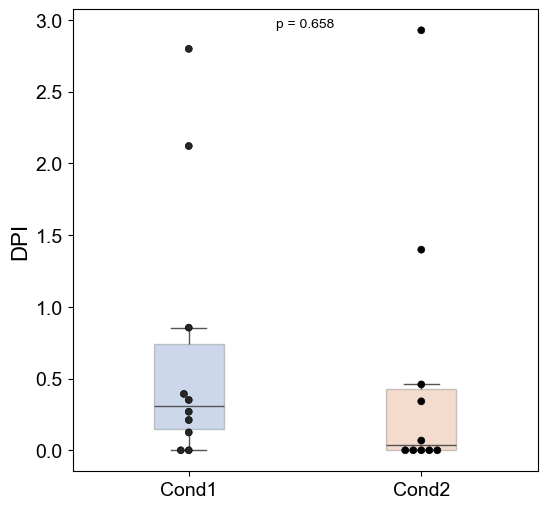

In [25]:
if Hot:
    save_path = 'HotIslands_Proximity_Index' + file_name.split('.')[0].split('_')[-1] +'.svg'
else:
    save_path = 'ColdIslands_Proximity_Index' + file_name.split('.')[0].split('_')[-1] +'.svg'
    
# Extract data for boxplot
balbc_data = [v[0] for k, v in PX_results[0].items()]
mrl_data = [v[0] for k, v in PX_results[1].items()]

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(balbc_data, mrl_data,equal_var=False) # p=0.01381

# Combining data
data = [balbc_data, mrl_data]
labels = ['Cond1', 'Cond2']

# Plotting
plt.figure(figsize=(6, 6))  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3, fliersize=0)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("DPI", fontsize=16)


# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/simulation/'+save_path)

plt.show()
plt.close(fig)